In [31]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from GA import GA


In [32]:
def readDatas(filePath):
    network = nx.read_gml(filePath)
    nodes = [node for node in network.nodes()]
    edges = [edge for edge in network.edges()]
    return nodes, edges

In [33]:
def createAdjacencyMatrix(nodes, edges):
    node_index = {node: idx for idx, node in enumerate(nodes)}
    
    size = len(nodes)
    adjacencyMatrix = [[0] * size for _ in range(size)]
    
    for edge in edges:
        pos_node1 = node_index[edge[0]]
        pos_node2 = node_index[edge[1]]
        adjacencyMatrix[pos_node1][pos_node2] = 1
        adjacencyMatrix[pos_node2][pos_node1] = 1
    
    return adjacencyMatrix

# Fitness functions

In [34]:
def getNodeDegree(node, adjacencyMatrix, nrNodes):
    degree = 0
    for i in range(0, nrNodes):
        if adjacencyMatrix[node][i] == 1:
            degree += 1
    return degree

def communityNodes(communities, community):
    indexes = []
    for i in range(0, len(communities)):
        if communities[i] == community:
            indexes.append(i)
    return indexes

def modularity(communities, parameters):
    # Q = (1/2*nrEdges)*sum(A[i][j]-degree[i]*degree[j]/(2*nrEdges))*C(i, j)
    # C(i, j) = 1, if i and j are in the same community
    #         = 0, otherwise
    
    adjacencyMatrix = parameters["adjacencyMatrix"]
    nrNodes = parameters["nrNodes"]
    nrEdges = parameters["nrEdges"]

    sum_el = 0
    for i in range(0, nrNodes):
        for j in range(0, nrNodes):
            # check if nodes are in the same community
            if communities[i] == communities[j]:
                el = adjacencyMatrix[i][j]
                degreeNodeI = getNodeDegree(i, adjacencyMatrix, nrNodes)
                degreeNodeJ = getNodeDegree(j, adjacencyMatrix, nrNodes)
                sum_el += el - (degreeNodeI * degreeNodeJ) / (2 * nrEdges)
    modularity_result = sum_el / (4 * nrEdges)
    return modularity_result

def internalDensity(communities, problemParameters):
    # D = (2 * Ec) / (n * (n-1))
    # Ec is the number of edges in community c
    # n*(n−1)/2 is the total number of possible edges within c
    
    density = 0
    for community in set(communities):
        indexes = communityNodes(communities, community)
        nrNodes = len(indexes)
        maxNrEdges = nrNodes * (nrNodes - 1) // 2

        nrEdges = 0
        for i in indexes:
            for j in indexes:
                if (problemParameters["nodes"][i], problemParameters["nodes"][j]) in problemParameters["edges"]:
                    nrEdges += 1
        if maxNrEdges != 0:
            density += nrEdges / maxNrEdges

    return density / len(set(communities))

def internalExternalConnectivity(communities, problemParameters):
    # I = nrInteriorEdges(C) / (nrInteriorEdges(C) + nrExteriorEdges(C) )
    
    connectivity = 0
    for community in set(communities):
        indexes = communityNodes(communities, community)

        nrExteriorEdges = 0
        for i in indexes:
            for j in [ind for ind in range(problemParameters["nrNodes"]) if ind not in indexes]:
                if (problemParameters["nodes"][i], problemParameters["nodes"][j]) in problemParameters["edges"]:
                    nrExteriorEdges += 1

        nrInteriorEdges = 0
        for i in indexes:
            for j in indexes:
                if (problemParameters["nodes"][i], problemParameters["nodes"][j]) in problemParameters["edges"]:
                    nrInteriorEdges += 1
                    
        if nrExteriorEdges != 0:
            connectivity += nrInteriorEdges / nrExteriorEdges
    return connectivity / len(set(communities))

In [35]:
def drawNetwork(title, network, communities=None):
    nodes, edges = network

    if communities == None:
        communities = [1 for _ in range(0, len(nodes))]

    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.spring_layout(g)


    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(g, pos, node_size=300, cmap=plt.cm.RdYlBu, node_color=communities)
    nx.draw_networkx_edges(g, pos, alpha=0.3)
    plt.title(title)
    plt.show()


def drawCommunities(community_name, network, fitness_function):
    nodes, edges = network

    gaParam = {'popSize': 10, 'noGen': 3, 'pc': 0.8, 'pm': 0.1}

    problParam = {'nodes': nodes, 'nrNodes': len(nodes), 'edges': edges, 'nrEdges': len(edges),
                  'fitnessFunction': fitness_function, 'adjacencyMatrix': createAdjacencyMatrix(nodes, edges)}

    allBestFitnesses = []
    allAvgFitnesses = []
    generations = []
    maxFitness = -9999
    bestSolution = []

    ga = GA(gaParam, problParam)
    ga.initialisation()
    ga.evaluation()

    print(community_name + ":")
    for g in range(gaParam['noGen']):
        allPotentialSolutionsX = [c.repres for c in ga.population]
        allPotentialSolutionsY = [c.fitness for c in ga.population]
        bestSolX = ga.bestChromosome().repres
        bestSolY = ga.bestChromosome().fitness
        allBestFitnesses.append(bestSolY)
        allAvgFitnesses.append(sum(allPotentialSolutionsY) / len(allPotentialSolutionsY))
        generations.append(g)

        ga.oneGeneration()

        bestChromo = ga.bestChromosome()
        if bestChromo.fitness > maxFitness:
            maxFitness = bestChromo.fitness
            bestSolution = bestChromo.repres

        print(f'Best solution in generation {g} is: x = {bestChromo.repres} fitness(x) = {bestChromo.fitness}')
    print(f"No. of communities: {len(bestSolution)}\n")

    drawNetwork(community_name, network, bestSolution)
    return bestSolution

dolphins:
Best solution in generation 0 is: x = [4, 3, 5, 5, 2, 6, 6, 4, 4, 3, 3, 4, 5, 6, 6, 4, 6, 2, 3, 1, 2, 1, 3, 2, 1, 6, 4, 6, 2, 4, 2, 6, 6, 1, 1, 3, 2, 1, 2, 2, 2, 5, 6, 3, 6, 5, 4, 1, 4, 2, 1, 5, 1, 5, 5, 6, 5, 4, 5, 6, 6, 2] fitness(x) = -0.014170721094893434
Best solution in generation 1 is: x = [5, 5, 1, 1, 2, 6, 6, 4, 4, 3, 3, 4, 5, 6, 6, 4, 6, 1, 3, 4, 6, 2, 6, 2, 5, 5, 1, 3, 1, 5, 5, 6, 5, 3, 1, 6, 4, 5, 1, 6, 1, 3, 4, 6, 6, 3, 2, 2, 2, 3, 3, 5, 3, 4, 2, 5, 3, 2, 2, 5, 2, 6] fitness(x) = -0.03514497053122893
Best solution in generation 2 is: x = [4, 3, 5, 5, 2, 6, 6, 4, 4, 3, 3, 4, 5, 6, 6, 4, 6, 2, 3, 1, 2, 1, 3, 2, 1, 6, 4, 6, 6, 4, 2, 6, 6, 5, 1, 3, 2, 1, 3, 2, 2, 5, 6, 3, 6, 5, 4, 1, 4, 2, 1, 5, 1, 5, 5, 6, 5, 4, 5, 6, 6, 2] fitness(x) = -0.02901388394446421
No. of communities: 62


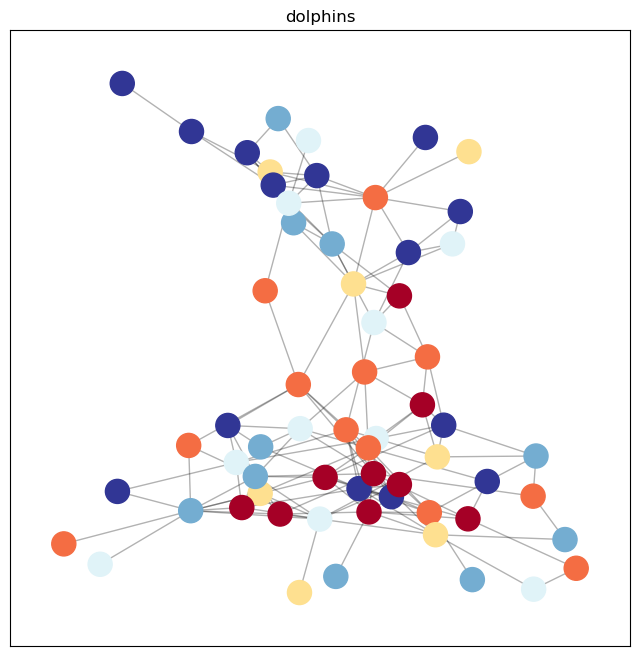

[4,
 3,
 5,
 5,
 2,
 6,
 6,
 4,
 4,
 3,
 3,
 4,
 5,
 6,
 6,
 4,
 6,
 2,
 3,
 1,
 2,
 1,
 3,
 2,
 1,
 6,
 4,
 6,
 2,
 4,
 2,
 6,
 6,
 1,
 1,
 3,
 2,
 1,
 2,
 2,
 2,
 5,
 6,
 3,
 6,
 5,
 4,
 1,
 4,
 2,
 1,
 5,
 1,
 5,
 5,
 6,
 5,
 4,
 5,
 6,
 6,
 2]

In [36]:
community_name = "dolphins"
network = readDatas(f"data/{community_name}.gml")
ffun = modularity
# ffun = internalDensity
# ffun = internalExternalConnectivity
drawCommunities(f"{community_name}", network, fitness_function=ffun)